In [1]:
import pybinding as pb
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt

# Model h_2b^4

In [412]:
lattice = pb.Lattice(a1=[1, 0], a2=[0, 1])
N = 4
lattice.add_sublattices(
    ('A', np.array([1, 1])*1/N), ('B', np.array([-1, -1])*1/N), ('C', np.array([1, -1])*1/N), ('D', np.array([-1, 1])*1/N)  # add an atom called 'A' at position [0, 0]
)
t = 0.4
t2 = 1
lattice.add_hoppings(
    ([0, 0], 'A', 'D', t),
    ([0, 0], 'A', 'C', t),
    ([0, 0], 'B', 'C', t),
    ([0, 0], 'B', 'D', t),
    ([1, 1], 'A', 'B', t2),
    ([-1, 1], 'D', 'C', t2),

)

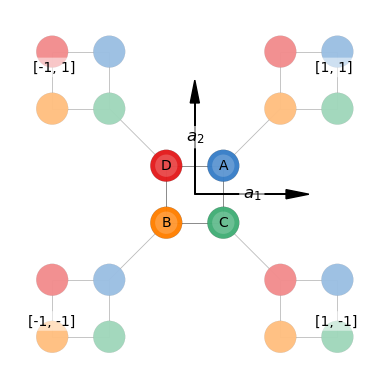

In [413]:
lattice.plot()
plt.gca().axis('off');

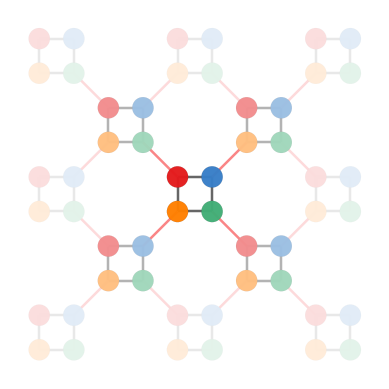

In [414]:
model = pb.Model(
    lattice,
    pb.translational_symmetry()
)

model.plot(num_periods=2,
          hopping = {
  "width": 3,
})
plt.gca().axis('off');

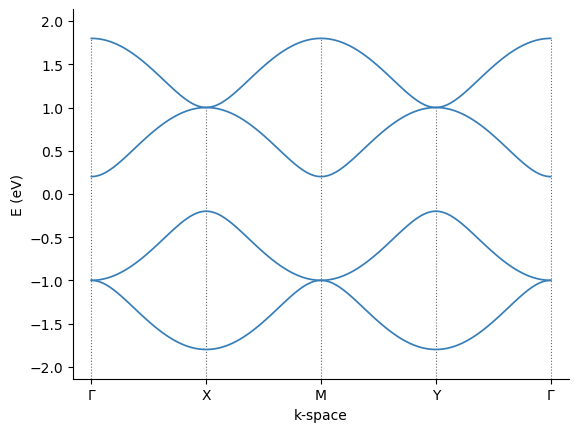

In [415]:
solver = pb.solver.lapack(model)
G1, G2 = lattice.reciprocal_vectors()
G1 = G1[0:2]
G2 = G2[0:2]
Gamma = np.array([0, 0])
X = 1/2*G1
M = 1/2*G1+1/2*G2
Y = 1/2*G2
bands = solver.calc_bands(Gamma, X, M, Y, Gamma)
bands.plot(point_labels=[r'$\Gamma$', 'X', 'M', 'Y',  r'$\Gamma$'])

# Symmetry Eigenvalues

In [416]:
R4 = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0]])
R2 = np.einsum("ij, jk -> ik", R4, R4)

In [417]:
solver.set_wave_vector(Gamma)
evectors = solver.eigenvectors
print(f"Gamma eigenvalues for R4: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R4, evectors), 3)}")
print(f"Gamma eigenvalues for R2: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R2, evectors), 3)}")
solver.set_wave_vector(X)
evectors = solver.eigenvectors
print(f"X eigenvalues for R2: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R2, evectors), 3)}")
solver.set_wave_vector(M)
evectors = solver.eigenvectors
print(f"M eigenvalues for R4: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R4, evectors), 3)}")

Gamma eigenvalues for R4: [-0.+0.j -0.+0.j -1.+0.j  1.+0.j]
Gamma eigenvalues for R2: [-1.+0.j -1.+0.j  1.+0.j  1.+0.j]
X eigenvalues for R2: [ 1.+0.j  1.+0.j -1.+0.j -1.+0.j]
M eigenvalues for R4: [-0.+0.j -0.+0.j -1.-0.j  1.+0.j]


In [418]:
a1 = np.array([1, 0])
a2 = np.array([0, 1])

lattice = pb.Lattice(a1 = a1, a2 = a2)

N = 4
M = 20
cladding = 12
for i in range(-M, M):
    for j in range(-M, M):
        if abs(i) > cladding:
            continue
        if abs(j) > cladding: 
            continue
        lattice.add_sublattices(
            (f'A{i} {j}', np.array([1, 1])*1/N +i*a1+j*a2), (f'B{i} {j}', np.array([-1, -1])*1/N +i*a1+j*a2),
            (f'C{i} {j}', np.array([1, -1])*1/N+i*a1+j*a2), (f'D{i} {j}', np.array([-1, 1])*1/N+i*a1+j*a2))

In [419]:
for i in range(-M, M):
    for j in range(-M, M):
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'D{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'C{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'B{i} {j}', f'C{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'B{i} {j}', f'D{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'B{i+1} {j+1}', t2)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'D{i} {j}', f'C{i-1} {j+1}', t2)
        except: 
            pass 

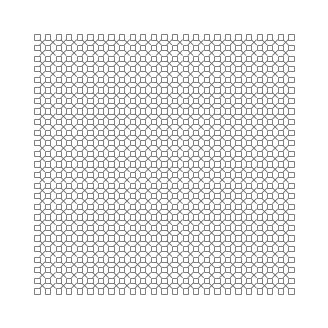

In [420]:
plt.figure(figsize=(4,4))
model = pb.Model(
    lattice,
)
model.plot()
plt.gca().axis('off');

# Supercell Bands, Corner Charge Wavefunctions, and Charge Density up to Gap

In [421]:
solver = pb.solver.lapack(model)
bands = solver.eigenvalues

In [422]:
prob = solver.calc_probability(range(0, 2*(2*cladding+1)**2-2))

In [423]:
dat = np.array([])
for i in range(0, int(prob.num_sites/4)):
    dat = np.append(dat, sum(prob.data[i*4:4*(i+1)]) - 2) 

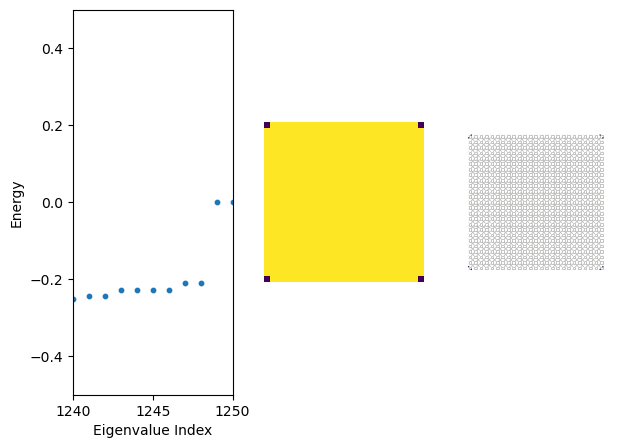

In [431]:
fig = plt.figure(figsize=(7,5))
fig.add_subplot(1, 3, 1)
plt.xlabel("Eigenvalue Index")
plt.ylabel("Energy")
plt.scatter(range(1, np.size(bands)+1), bands, s=10)
plt.xlim(1240, 1250)
plt.ylim(-0.5, 0.5);

fig.add_subplot(1, 3, 2)
plt.imshow(np.reshape(dat, (2*cladding+1, 2*cladding+1)))
plt.gca().axis('off');

fig.add_subplot(1, 3, 3)
ldos = solver.calc_spatial_ldos(energy=0, broadening=0.01)  # eV
ldos.plot(site_radius=(0.03, 0.12))
plt.gca().axis('off');

# h_1b^4 model

In [432]:
lattice = pb.Lattice(a1=[1, 0], a2=[0, 1])
N = 4
lattice.add_sublattices(
    ('A', np.array([1, 1])*1/N), ('B', np.array([-1, -1])*1/N), ('C', np.array([1, -1])*1/N), ('D', np.array([-1, 1])*1/N)  # add an atom called 'A' at position [0, 0]
)
t = 0.5
tx = ty =  1
lattice.add_hoppings(
    ([0, 0], 'A', 'D', t),
    ([0, 0], 'A', 'C', t),
    ([0, 0], 'B', 'C', t),
    ([0, 0], 'B', 'D', t),
    ([1, 0], 'A', 'D', tx),
    ([0, 1], 'A', 'C', ty),
    ([0, -1], 'B', 'D', ty),
    ([-1, 0], 'B', 'C', tx),

)

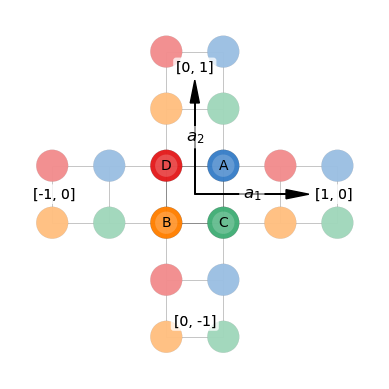

In [433]:
lattice.plot()
plt.gca().axis('off');

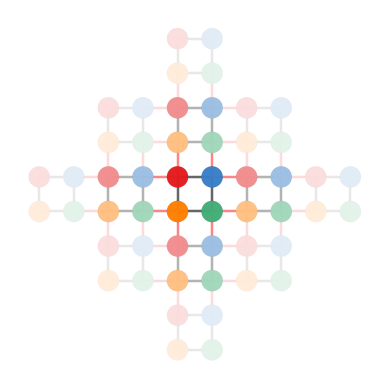

In [434]:
model = pb.Model(
    lattice,
    pb.translational_symmetry()
)
model.plot(num_periods=2,
          hopping = {
  "width": 3,
})
plt.gca().axis('off');

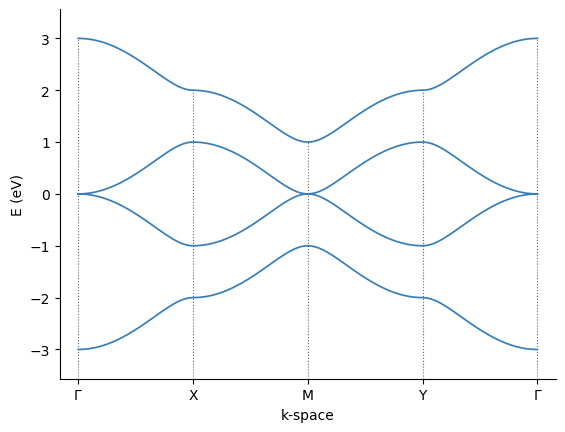

In [435]:
solver = pb.solver.lapack(model)
G1, G2 = lattice.reciprocal_vectors()
G1 = G1[0:2]
G2 = G2[0:2]
Gamma = np.array([0, 0])
X = 1/2*G1
M = 1/2*G1+1/2*G2
Y = 1/2*G2
bands = solver.calc_bands(Gamma, X, M, Y, Gamma)
bands.plot(point_labels=[r'$\Gamma$', 'X', 'M', 'Y',  r'$\Gamma$'])

# Symmetry Eigenvalues

In [436]:
R4 = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0]])
R2 = np.einsum("ij, jk -> ik", R4, R4)

In [437]:
solver.set_wave_vector(Gamma)
evectors = solver.eigenvectors
print(f"Gamma eigenvalues for R4: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R4, evectors), 3)}")
print(f"Gamma eigenvalues for R2: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R2, evectors), 3)}")
solver.set_wave_vector(X)
evectors = solver.eigenvectors
print(f"X eigenvalues for R2: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R2, evectors), 3)}")
solver.set_wave_vector(M)
evectors = solver.eigenvectors
print(f"M eigenvalues for R4: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R4, evectors), 3)}")

Gamma eigenvalues for R4: [-1.+0.j  0.+0.j -0.+0.j  1.+0.j]
Gamma eigenvalues for R2: [ 1.+0.j -1.+0.j -1.+0.j  1.+0.j]
X eigenvalues for R2: [-1.+0.j  1.+0.j  1.+0.j -1.+0.j]
M eigenvalues for R4: [ 1.+0.j  0.+0.j  0.+0.j -1.+0.j]


# h_2c^4 model

In [438]:
lattice = pb.Lattice(a1=[1, 0], a2=[0, 1])
N = 4
lattice.add_sublattices(
    ('A', np.array([0, 1])*1/N), ('B', np.array([-1, 0])*1/N), ('C', np.array([0, -1])*1/N), ('D', np.array([1, 0])*1/N)  # add an atom called 'A' at position [0, 0]
)
t = 0.5
tx = ty =  1
lattice.add_hoppings(
    ([0, 0], 'A', 'C', t),
    ([0, 0], 'B', 'D', t),
    ([0, 1], 'A', 'C', ty),
    ([1, 0], 'D', 'B', tx),
)

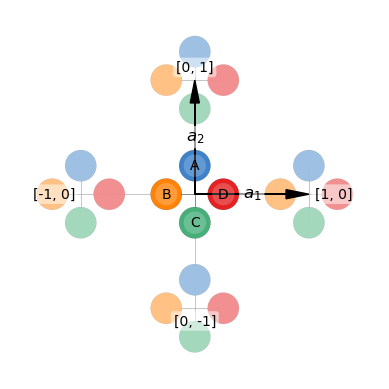

In [439]:
lattice.plot()
plt.gca().axis('off');

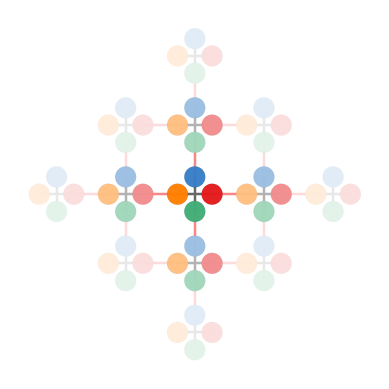

In [440]:
model = pb.Model(
    lattice,
    pb.translational_symmetry()
)
model.plot(num_periods=2,
          hopping = {
  "width": 3,
})
plt.gca().axis('off');

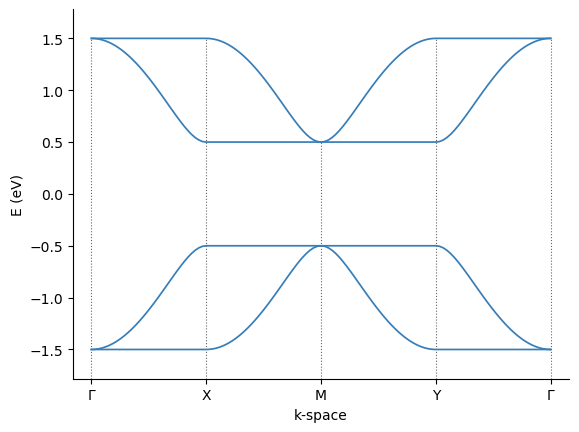

In [441]:
solver = pb.solver.lapack(model)
G1, G2 = lattice.reciprocal_vectors()
G1 = G1[0:2]
G2 = G2[0:2]
Gamma = np.array([0, 0])
X = 1/2*G1
M = 1/2*G1+1/2*G2
Y = 1/2*G2
bands = solver.calc_bands(Gamma, X, M, Y, Gamma)
bands.plot(point_labels=[r'$\Gamma$', 'X', 'M', 'Y',  r'$\Gamma$'])

# Symmetry Eigenvalues

In [442]:
R4 = np.array([[0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
R2 = np.einsum("ij, jk -> ik", R4, R4)

In [443]:
solver.set_wave_vector(Gamma)
evectors = solver.eigenvectors
print(f"Gamma eigenvalues for R4: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R4, evectors), 3)}")
print(f"Gamma eigenvalues for R2: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R2, evectors), 3)}")
solver.set_wave_vector(X)
evectors = solver.eigenvectors
print(f"X eigenvalues for R2: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R2, evectors), 3)}")
solver.set_wave_vector(M)
evectors = solver.eigenvectors
print(f"M eigenvalues for R4: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R4, evectors), 3)}")
print(f"M eigenvalues for R2: {np.round(np.einsum('il, ij, jl -> l', np.conj(evectors), R2, evectors), 3)}")

Gamma eigenvalues for R4: [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Gamma eigenvalues for R2: [-1.+0.j -1.+0.j  1.+0.j  1.+0.j]
X eigenvalues for R2: [-1.+0.j  1.+0.j -1.+0.j  1.+0.j]
M eigenvalues for R4: [ 0.+0.j -0.-0.j  0.+0.j  0.+0.j]
M eigenvalues for R2: [ 1.+0.j  1.+0.j -1.+0.j -1.+0.j]


# Stacking the two models

In [444]:
lattice = pb.Lattice(a1=[1, 0], a2=[0, 1])
N = 4
lattice.add_sublattices(
    ('A', np.array([0, 1])*1/N), ('B', np.array([-1, 0])*1/N), ('C', np.array([0, -1])*1/N), ('D', np.array([1, 0])*1/N)  # add an atom called 'A' at position [0, 0]
)
t = 0.1
tx = ty =  1
lattice.add_hoppings(
    ([0, 0], 'A', 'C', t),
    ([0, 0], 'B', 'D', t),
    ([0, 1], 'A', 'C', ty),
    ([1, 0], 'D', 'B', tx),
)
lattice.add_sublattices(
    ('AA', np.array([1, 1])*1/N), ('BB', np.array([-1, -1])*1/N), ('CC', np.array([1, -1])*1/N), ('DD', np.array([-1, 1])*1/N)  # add an atom called 'A' at position [0, 0]
)
lattice.add_hoppings(
    ([0, 0], 'AA', 'DD', t),
    ([0, 0], 'AA', 'CC', t),
    ([0, 0], 'BB', 'CC', t),
    ([0, 0], 'BB', 'DD', t),
    ([1, 0], 'AA', 'DD', tx),
    ([0, 1], 'AA', 'CC', ty),
    ([0, -1], 'BB', 'DD', ty),
    ([-1, 0], 'BB', 'CC', tx),
)

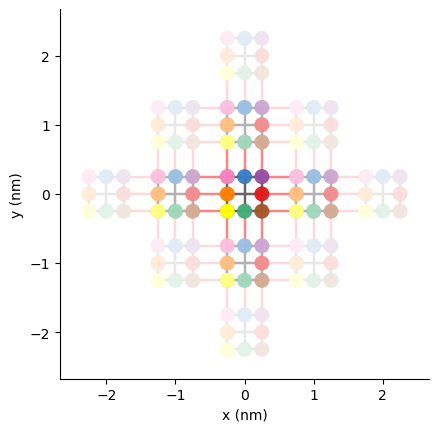

In [445]:
model = pb.Model(
    lattice,
    pb.translational_symmetry()
)
model.plot(num_periods=2,
          hopping = {
  "width": 3,
})

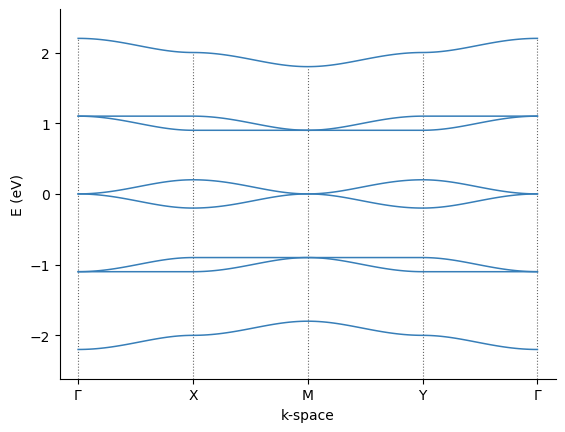

In [446]:
solver = pb.solver.lapack(model)
G1, G2 = lattice.reciprocal_vectors()
G1 = G1[0:2]
G2 = G2[0:2]
Gamma = np.array([0, 0])
X = 1/2*G1
M = 1/2*G1+1/2*G2
Y = 1/2*G2
bands = solver.calc_bands(Gamma, X, M, Y, Gamma)
bands.plot(point_labels=[r'$\Gamma$', 'X', 'M', 'Y',  r'$\Gamma$'])

In [447]:
a1 = np.array([1, 0])
a2 = np.array([0, 1])

lattice = pb.Lattice(a1=a1, a2=a2)

N = 4
M = 30
cladding = 9
for i in range(-M, M):
    for j in range(-M, M):
        if abs(i) > cladding:
            continue
        if abs(j) > cladding: 
            continue
        lattice.add_sublattices(
            (f'A{i} {j}', np.array([0, 1])*1/N +i*a1+j*a2), (f'B{i} {j}', np.array([-1, 0])*1/N +i*a1+j*a2),
            (f'C{i} {j}', np.array([0, -1])*1/N+i*a1+j*a2), (f'D{i} {j}', np.array([1, 0])*1/N+i*a1+j*a2))
        lattice.add_sublattices(
            (f'AA{i} {j}', np.array([1, 1])*1/N+i*a1+j*a2), (f'BB{i} {j}', np.array([-1, -1])*1/N+i*a1+j*a2), 
            (f'CC{i} {j}', np.array([1, -1])*1/N+i*a1+j*a2), (f'DD{i} {j}', np.array([-1, 1])*1/N+i*a1+j*a2))

In [448]:
t = 0.1
tx = ty =  1
for i in range(-M, M):
    for j in range(-M, M):
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'C{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'B{i} {j}', f'D{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'C{i} {j+1}', ty)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'D{i+1} {j}', f'B{i} {j}', tx)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'DD{i} {j}', t)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'CC{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'CC{i} {j}', t)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'DD{i} {j}', t)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'DD{i+1} {j}', tx)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'CC{i} {j+1}', ty)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'DD{i} {j-1}', ty)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'CC{i-1} {j}', tx)
        except: 
            pass

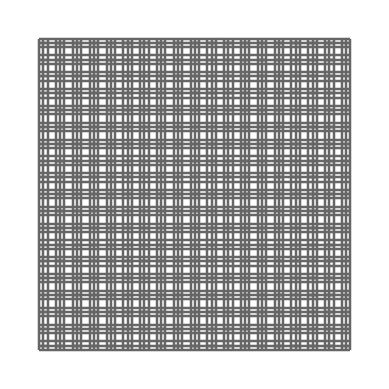

In [449]:
model = pb.Model(
    lattice,
)
model.plot(num_periods=2,
          hopping = {
  "width": 3,
})
plt.gca().axis('off');

In [457]:
solver = pb.solver.lapack(model)
bands = solver.eigenvalues
prob_gap_two = solver.calc_probability(range(0, 3*(2*cladding+1)**2-3))
prob_gap_one = solver.calc_probability(range(0, 324))

In [460]:
dat_gap_one = np.array([])
for i in range(0, int(prob_gap_one.num_sites/8)):
    dat_gap_one = np.append(dat_gap_one, sum(prob_gap_one.data[i*8:8*(i+1)]) - 3) 
dat_gap_two = np.array([])
for i in range(0, int(prob_gap_two.num_sites/8)):
    dat_gap_two = np.append(dat_gap_two, sum(prob_gap_two.data[i*8:8*(i+1)]) - 1) 

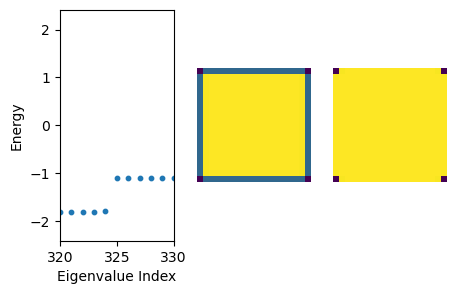

In [461]:
fig = plt.figure(figsize=(5,3))
fig.add_subplot(1, 3, 1)
plt.xlabel("Eigenvalue Index")
plt.ylabel("Energy")
plt.scatter(range(1, np.size(bands)+1), bands, s=10)
plt.xlim(320, 330)
#plt.xlim(3*(2*cladding+1)**2-10, 3*(2*cladding+1)**2);
fig.add_subplot(1, 3, 2)
plt.imshow(np.reshape(dat_gap_one, (2*cladding+1, 2*cladding+1)))
plt.gca().axis('off');
fig.add_subplot(1, 3, 3)
plt.imshow(np.reshape(dat_gap_two, (2*cladding+1, 2*cladding+1)))
plt.gca().axis('off');

# Stacking two copies of h_1b^4

In [318]:
lattice = pb.Lattice(a1=[1, 0], a2=[0, 1])
N = 4
t = 0.1
tx = ty =  1
lattice.add_sublattices(
    ('AA', np.array([1, 1])*1/N), ('BB', np.array([-1, -1])*1/N), ('CC', np.array([1, -1])*1/N), ('DD', np.array([-1, 1])*1/N)  # add an atom called 'A' at position [0, 0]
)
lattice.add_hoppings(
    ([0, 0], 'AA', 'DD', t),
    ([0, 0], 'AA', 'CC', t),
    ([0, 0], 'BB', 'CC', t),
    ([0, 0], 'BB', 'DD', t),
    ([1, 0], 'AA', 'DD', tx),
    ([0, 1], 'AA', 'CC', ty),
    ([0, -1], 'BB', 'DD', ty),
    ([-1, 0], 'BB', 'CC', tx),
)
lattice.add_sublattices(
    ('A', np.array([1, 1])*1/N), ('B', np.array([-1, -1])*1/N), ('C', np.array([1, -1])*1/N), ('D', np.array([-1, 1])*1/N)  # add an atom called 'A' at position [0, 0]
)
t = 0.2
lattice.add_hoppings(
    ([0, 0], 'A', 'D', t),
    ([0, 0], 'A', 'C', t),
    ([0, 0], 'B', 'C', t),
    ([0, 0], 'B', 'D', t),
    ([1, 0], 'A', 'D', tx),
    ([0, 1], 'A', 'C', ty),
    ([0, -1], 'B', 'D', ty),
    ([-1, 0], 'B', 'C', tx),
)

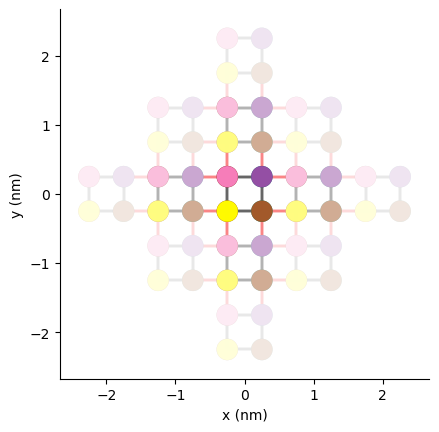

In [319]:
model = pb.Model(
    lattice,
    pb.translational_symmetry()
)
model.plot(num_periods=2,
          hopping = {
  "width": 3,
})

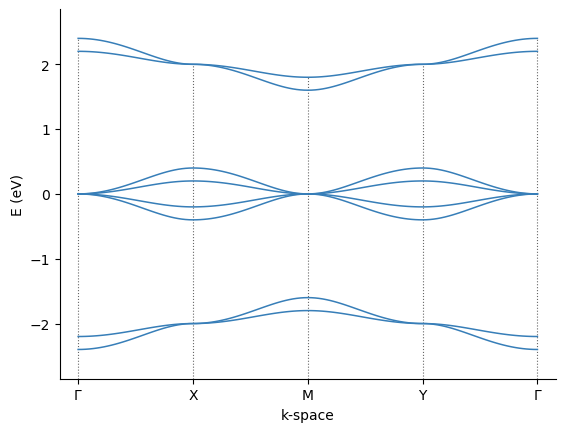

In [320]:
solver = pb.solver.lapack(model)
G1, G2 = lattice.reciprocal_vectors()
G1 = G1[0:2]
G2 = G2[0:2]
Gamma = np.array([0, 0])
X = 1/2*G1
M = 1/2*G1+1/2*G2
Y = 1/2*G2
bands = solver.calc_bands(Gamma, X, M, Y, Gamma)
bands.plot(point_labels=[r'$\Gamma$', 'X', 'M', 'Y',  r'$\Gamma$'])

In [321]:
a1 = np.array([1, 0])
a2 = np.array([0, 1])

lattice = pb.Lattice(a1=a1, a2=a2)

N = 4
M = 30
cladding = 8
for i in range(-M, M):
    for j in range(-M, M):
        if abs(i) > cladding:
            continue
        if abs(j) > cladding: 
            continue
        lattice.add_sublattices(
            (f'A{i} {j}', np.array([1, 1])*1/N+i*a1+j*a2), (f'B{i} {j}', np.array([-1, -1])*1/N+i*a1+j*a2), 
            (f'C{i} {j}', np.array([1, -1])*1/N+i*a1+j*a2), (f'D{i} {j}', np.array([-1, 1])*1/N+i*a1+j*a2))
        lattice.add_sublattices(
            (f'AA{i} {j}', np.array([1, 1])*1/N+i*a1+j*a2), (f'BB{i} {j}', np.array([-1, -1])*1/N+i*a1+j*a2), 
            (f'CC{i} {j}', np.array([1, -1])*1/N+i*a1+j*a2), (f'DD{i} {j}', np.array([-1, 1])*1/N+i*a1+j*a2))

In [322]:
t = 0.1
t2 = 0.2
tx = ty =  1
for i in range(-M, M):
    for j in range(-M, M):
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'DD{i} {j}', t)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'CC{i} {j}', t)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'CC{i} {j}', t)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'DD{i} {j}', t)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'DD{i+1} {j}', tx)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'AA{i} {j}', f'CC{i} {j+1}', ty)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'DD{i} {j-1}', ty)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'BB{i} {j}', f'CC{i-1} {j}', tx)
        except: 
            pass
        

        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'D{i} {j}', t2)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'C{i} {j}', t2)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'B{i} {j}', f'C{i} {j}', t2)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'B{i} {j}', f'D{i} {j}', t2)
        except: 
            pass 
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'D{i+1} {j}', tx)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'A{i} {j}', f'C{i} {j+1}', ty)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'B{i} {j}', f'D{i} {j-1}', ty)
        except: 
            pass
        try:
            lattice.add_one_hopping([0, 0], f'B{i} {j}', f'C{i-1} {j}', tx)
        except: 
            pass

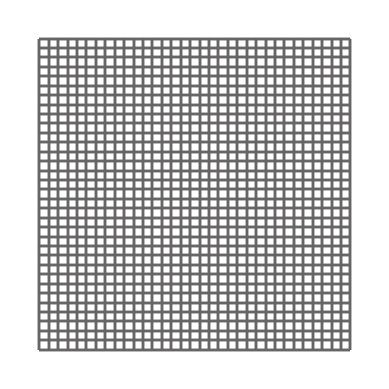

In [323]:
model = pb.Model(
    lattice,
)
model.plot(num_periods=2,
          hopping = {
  "width": 3,
})
plt.gca().axis('off');

In [324]:
solver = pb.solver.lapack(model)
bands = solver.eigenvalues

In [398]:
prob_gap_one = solver.calc_probability(range(0, 512))
prob_gap_two = solver.calc_probability(range(0, 640))

In [403]:
dat_gap_one = np.array([])
for i in range(0, int(prob_gap_one.num_sites/8)):
    dat_gap_one = np.append(dat_gap_one, sum(prob_gap_one.data[i*8:8*(i+1)]) - 2) 
dat_gap_two = np.array([])
for i in range(0, int(prob_gap_two.num_sites/8)):
    dat_gap_two = np.append(dat_gap_two, sum(prob_gap_two.data[i*8:8*(i+1)]) - 2) 

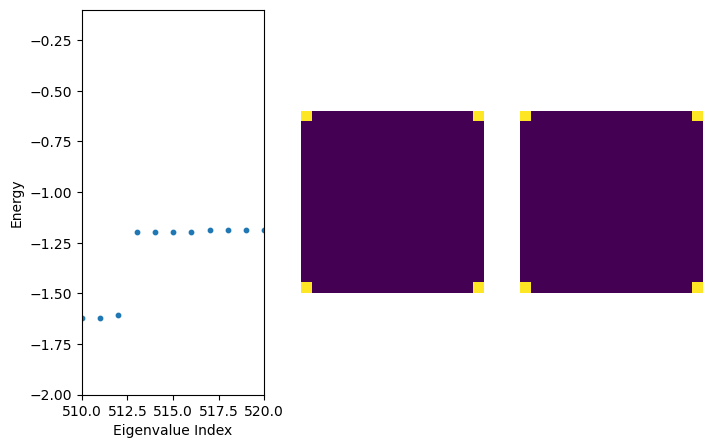

In [411]:
fig = plt.figure(figsize=(8,5))
fig.add_subplot(1, 3, 1)
plt.xlabel("Eigenvalue Index")
plt.ylabel("Energy")
plt.scatter(range(1, np.size(bands)+1), bands, s=10)
#plt.xlim(510, 645)
plt.xlim(510, 520)

plt.ylim(-2, -0.1)
fig.add_subplot(1, 3, 2)
plt.gca().imshow(np.reshape(np.mod(np.round(dat_gap_one, 1), 1), (2*cladding+1, 2*cladding+1)))
plt.gca().axis('off')
fig.add_subplot(1, 3, 3)
plt.gca().imshow(np.reshape(np.mod(np.round(dat_gap_two, 1), 1), (2*cladding+1, 2*cladding+1)))
plt.gca().axis('off');